In [50]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc, classification_report
)
!pip install rapidfuzz

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import joblib

RANDOM_STATE = 42

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## **1. Data Loading**

In [51]:
DATA_DIR = Path("./data")
train = pd.read_csv(DATA_DIR/"train.csv")
test  = pd.read_csv(DATA_DIR/"test.csv")

REGION_REF_PATH = DATA_DIR / 'region_reference.csv'

In [52]:
optimized_types = {
    'monthly_income': np.float32, 
    'work_experience': np.float32, 
    'requested_sum': np.float32,
    'main_agreement_amount': np.float32, 
    'main_agreement_term': np.float32,
    'requested_period_days': np.float32, 
    'requested_amount': np.float32, 
    'req_app_amount': np.float32,
    'approved_amount': np.float32, 
    'period_days': np.float32, 
    'days_finish_loan': np.float32,
    'ag': np.float32, 
    'cnt_ext': np.float32, 
    'term': np.float32, 
    'price': np.float32,
    'elecs_sum': np.float32, 
    'recurents_sum': np.float32, 
    'tamount': np.float32, 
    'issues': np.float32,
    'principal': np.float32, 
    'interest': np.float32, 
    'overdue_interest': np.float32, 
    'overdue_fee': np.float32,
    'nbki_score': np.float32, 
    'contact_cases': np.float32,
    'payment_frequency': np.int32, 
    'status': np.int32, 
    'loan_id': np.int32, 
    'client_id': np.int32,
    'source': np.int32, 
    'first_source': np.int32, 
    'interface': np.int32, 
    'type': np.int32,
    'repayment_type': np.int32, 
    'client_type': np.int32, 
    'loan_order': np.int32, 
    'have_extension': np.int32,
    'churn': np.int32,
    'settlement': 'category', 
    'client_type.1': 'category', 
    'region': 'category', 
    'gender': 'category',
    'created_at': 'datetime64[ns]', 
    'closed_at': 'datetime64[ns]', 
    'start_dt': 'datetime64[ns]'
}

In [53]:
train['created_at'] = pd.to_datetime(train['created_at'])
train['start_dt']   = pd.to_datetime(train['start_dt'])
test['created_at']  = pd.to_datetime(test['created_at'])
test['start_dt']    = pd.to_datetime(test['start_dt'])

train = train.astype(optimized_types)
optimized_types_test = {col: dtype for col, dtype in optimized_types.items() if col in test.columns}
test = test.astype(optimized_types_test)


In [54]:
train.drop(columns=['closed_at'], inplace=True)
test.drop(columns=['closed_at'], inplace=True, errors = 'ignore')

In [55]:
train.head()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,-0.629296,-0.61762,-0.340659,-0.539616,-0.619312,NaN,NaN,NaN,-0.063933,-0.143015,-0.434972,0.347703,-0.347703,-0.502878,-0.218265,-0.185707,1.837623,2,1,464867,111035,11,0,0,2,3,1,г Москва,repeated,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaT,0
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.020140,-0.61762,-1.145865,-0.539616,1.354330,NaN,NaN,NaN,-0.063933,-0.143015,-0.434972,0.347703,-0.347703,-0.502878,-0.218265,-0.185707,2.262600,2,1,4569010,604426,11,0,2,1,0,1,г Москва,repeated,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaT,0
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,0.153905,-0.61762,-0.685747,-0.502706,1.354330,NaN,NaN,NaN,-0.063933,-0.143015,-0.429509,0.347703,-0.347703,-0.484111,-0.218265,-0.185707,2.262600,2,1,985489,334703,11,4,2,2,3,1,г Пермь,repeated,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaT,0
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,1.633284,-0.61762,0.176974,-0.465796,1.354330,NaN,NaN,NaN,-0.063933,-0.143015,-0.413118,0.347703,-0.347703,-0.427809,-0.218265,-0.185707,2.262600,2,6,2247534,362893,11,0,2,2,1,1,г Самара,repeated,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,0.763061,-0.61762,-1.145865,-0.133607,1.354330,1.407752,-0.612324,-0.705103,-0.063933,-0.143015,-0.320236,0.347703,-0.347703,-0.108766,-0.218265,-0.185707,2.262600,2,1,4695006,537669,11,11,2,1,2,1,г Москва,repeated,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaT,0


In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 44 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   monthly_income         float32       
 1   work_experience        float32       
 2   requested_sum          float32       
 3   main_agreement_amount  float32       
 4   main_agreement_term    float32       
 5   requested_period_days  float32       
 6   requested_amount       float32       
 7   req_app_amount         float32       
 8   approved_amount        float32       
 9   period_days            float32       
 10  days_finish_loan       float32       
 11  ag                     float32       
 12  cnt_ext                float32       
 13  term                   float32       
 14  price                  float32       
 15  elecs_sum              float32       
 16  recurents_sum          float32       
 17  tamount                float32       
 18  issues                

In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   monthly_income         1348680 non-null  float32       
 1   work_experience        463225 non-null   float32       
 2   requested_sum          163790 non-null   float32       
 3   main_agreement_amount  1348743 non-null  float32       
 4   main_agreement_term    1348743 non-null  float32       
 5   requested_period_days  1200882 non-null  float32       
 6   requested_amount       1209772 non-null  float32       
 7   req_app_amount         1209772 non-null  float32       
 8   approved_amount        1348743 non-null  float32       
 9   period_days            1348743 non-null  float32       
 10  days_finish_loan       1348743 non-null  float32       
 11  ag                     1348743 non-null  float32       
 12  cnt_ext                15170

In [58]:
train.isna().sum()

monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days     441618
requested_amount          414836
req_app_amount            414836
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  3582556
term                     3582556
price                    3582816
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

In [59]:
test.isna().sum()

monthly_income                63
work_experience           885518
requested_sum            1184953
main_agreement_amount          0
main_agreement_term            0
requested_period_days     147861
requested_amount          138971
req_app_amount            138971
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  1197042
term                     1197042
price                    1197133
elecs_sum                   1984
recurents_sum               1984
tamount                      618
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 27977
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

## **2. Filling missing values**

In [61]:
train['start_dt'] = train.groupby('client_id')['start_dt'].transform(lambda x: x.fillna(x.min()))
train['start_dt'] = train['start_dt'].fillna(train['created_at'])

test['start_dt'] = test.groupby('client_id')['start_dt'].transform(lambda x: x.fillna(x.min()))
test['start_dt'] = test['start_dt'].fillna(test['created_at'])


In [62]:
num_cols = [
    'monthly_income','work_experience','requested_sum','main_agreement_amount',
    'main_agreement_term','requested_period_days','requested_amount','req_app_amount',
    'approved_amount','period_days','days_finish_loan','ag','cnt_ext','term','price',
    'elecs_sum','recurents_sum','tamount','issues','principal','interest',
    'overdue_interest','overdue_fee','nbki_score','contact_cases'
]

for col in num_cols:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

zero_cols = ['term', 'price', 'cnt_ext'] 
for col in zero_cols:
    train[col] = train[col].fillna(0)
    test[col]  = test[col].fillna(0)

ratio = train['requested_sum'].median() / train['approved_amount'].median()
train['requested_sum'] = train['requested_sum'].fillna(train['approved_amount'] * ratio)
test['requested_sum']  = test['requested_sum'].fillna(test['approved_amount'] * ratio)

train['requested_amount'] = train['requested_amount'].fillna(train['requested_sum'])
test['requested_amount']  = test['requested_amount'].fillna(test['requested_sum'])

train['req_app_amount'] = train['requested_amount'] - train['approved_amount']
test['req_app_amount']  = test['requested_amount']  - test['approved_amount']

train['tamount'] = train['tamount'].fillna(train['principal'] + train['interest'] + train['issues'])
test['tamount']  = test['tamount'].fillna(test['principal']  + test['interest']  + test['issues'])


## **3. Feature engineering**

In [63]:
# Обработаем названия городов
region_ref = pd.read_csv(REGION_REF_PATH)
region_ref['region_reference'] = region_ref['region_reference'].str.lower().str.strip()
reference_list = region_ref['region_reference'].tolist()

In [66]:
import re
from rapidfuzz import process, fuzz

def clean_city_name(name) -> str:
    if pd.isna(name):
        return ''
    s = str(name).strip().lower()
    s = s.split()[-1]  
    s = re.sub(r'[^а-яa-z0-9]', '', s)
    return s
    
def match_city(name: str) -> str:
    # Возвращаем похожее название из reference_list (порог 60%)
    m = process.extractOne(name, reference_list, scorer=fuzz.ratio)
    return m[0] if (m and m[1] >= 60) else name

train['settlement'] = train['settlement'].map(clean_city_name)
test['settlement']  = test['settlement'].map(clean_city_name)
train['settlement'] = train['settlement'].apply(match_city)
test['settlement']  = test['settlement'].apply(match_city)

# Для редких городов создадим отдельную категорию
val_cnt = train['settlement'].value_counts()
rare = set(val_cnt[val_cnt < 400].index)
train['settlement'] = np.where(train['settlement'].isin(rare), 'другие', train['settlement'])
test['settlement']  = np.where(test['settlement'].isin(rare),  'другие', test['settlement'])

In [67]:
train['settlement'] = train['settlement'].astype('category')
test['settlement']  = test['settlement'].astype('category')

In [68]:
# Платежное поведение
train['payment_to_income_ratio'] = train['tamount'] / train['monthly_income'].replace(0, np.nan)
test['payment_to_income_ratio']  = test['tamount']  / test['monthly_income'].replace(0, np.nan)

train['interest_to_principal_ratio'] = train['interest'] / train['principal'].replace(0, np.nan)
test['interest_to_principal_ratio']  = test['interest'] / test['principal'].replace(0, np.nan)

train['overdue_ratio'] = (train['overdue_interest'] + train['overdue_fee']) / train['principal'].replace(0, np.nan)
test['overdue_ratio']  = (test['overdue_interest']  + test['overdue_fee'])  / test['principal'].replace(0, np.nan)

# Временные признаки
train['early_repayment'] = train['period_days'] - train['days_finish_loan']
test['early_repayment']  = test['period_days']  - test['days_finish_loan']

# Кредитное поведение
train['approval_ratio'] = train['approved_amount'] / train['requested_amount'].replace(0, np.nan)
test['approval_ratio']  = test['approved_amount']  / test['requested_amount'].replace(0, np.nan)

train['previous_extensions'] = train['cnt_ext'].fillna(0)
train['had_extensions']      = train['cnt_ext'].notna().astype(int)
test['previous_extensions']  = test['cnt_ext'].fillna(0)
test['had_extensions']       = test['cnt_ext'].notna().astype(int)

# Риск-скор
train['risk_score'] = (-1.0 * train['nbki_score']) + (2.0 * train['overdue_ratio']) + (1.5 * train['had_extensions'])
test['risk_score']  = (-1.0 * test['nbki_score'])  + (2.0 * test['overdue_ratio'])  + (1.5 * test['had_extensions'])

# Финансовая нагрузка
train['total_debt_burden'] = (train['elecs_sum'] + train['recurents_sum']) / train['monthly_income'].replace(0, np.nan)
test['total_debt_burden']  = (test['elecs_sum']  + test['recurents_sum'])  / test['monthly_income'].replace(0, np.nan)
train['disposable_income_ratio'] = 1 - train['total_debt_burden']
test['disposable_income_ratio']  = 1 - test['total_debt_burden']

# Поведение
train['digital_engagement']  = ((train['interface'] == 2) | (train['source'].isin([11,12]))).astype(int)
test['digital_engagement']   = ((test['interface']  == 2) | (test['source'].isin([11,12]))).astype(int)
train['prefers_longer_terms'] = (train['requested_period_days'] > train['requested_period_days'].mean()).astype(int)
test['prefers_longer_terms']  = (test['requested_period_days']  > train['requested_period_days'].mean()).astype(int)

# Агрегаты по каждому клиенту
client_features = train.groupby('client_id').agg({
    'loan_id': 'count',
    'days_finish_loan': 'mean',
    'approved_amount': 'mean',
    'cnt_ext': 'sum',
    'elecs_sum': 'sum',
    'created_at': 'max',
    'monthly_income': 'std',
    'contact_cases': 'sum'
}).reset_index().rename(columns={
    'loan_id': 'total_loans',
    'days_finish_loan': 'avg_days_finish_loan',
    'approved_amount': 'avg_approved_amount',
    'cnt_ext': 'total_extensions',
    'elecs_sum': 'total_fees',
    'created_at': 'last_loan_date',
    'monthly_income': 'income_variation',
    'contact_cases': 'total_contacts'
})

train = train.merge(client_features, on='client_id', how='left')
test  = test.merge(client_features, on='client_id', how='left')


In [69]:
train.head()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,payment_to_income_ratio,interest_to_principal_ratio,overdue_ratio,early_repayment,approval_ratio,previous_extensions,had_extensions,risk_score,total_debt_burden,disposable_income_ratio,digital_engagement,prefers_longer_terms,total_loans,avg_days_finish_loan,avg_approved_amount,total_extensions,total_fees,last_loan_date,income_variation,total_contacts
0,-0.000735,0.952894,-0.267427,-0.388291,-0.340659,-0.389028,-1.053530,-0.435910,-0.61762,-0.340659,-0.539616,-0.619312,-0.720608,-0.561187,-0.343282,-0.063933,-0.143015,-0.434972,0.347703,-0.347703,-0.502878,-0.218265,-0.185707,1.837623,2,1,464867,111035,11,0,0,2,3,1,г. москва,repeated,г Москва,male,2,0,1.0,2022-12-23 17:50:25,2022-12-23 17:50:25,0,592.095581,1.446286,1.16183,0.198957,0.586239,-0.720608,1,1.986038,281.702759,-280.702759,1,0,13,-0.190391,0.338277,-9.367906,-0.831123,2023-07-07 21:36:02,0.000006,13.0
1,-0.000742,0.952894,-0.267427,-0.388291,-1.145865,-1.294731,-0.436189,0.181431,-0.61762,-1.145865,-0.539616,1.354330,-0.720608,-0.561187,-0.343282,-0.063933,-0.143015,-0.434972,0.347703,-0.347703,-0.502878,-0.218265,-0.185707,2.262600,2,1,4569010,604426,11,0,2,1,0,1,г. москва,repeated,г Москва,female,14,0,1.0,2024-06-29 22:26:08,2024-06-29 22:26:08,0,586.407837,1.446286,1.16183,-0.606250,1.415945,-0.720608,1,1.561061,278.996674,-277.996674,1,0,16,-0.085163,-0.258516,-11.529730,2.392038,2024-08-22 23:49:16,0.000007,16.0
2,-0.000742,0.952894,-0.267427,-0.388291,-0.685747,-1.113590,-0.259806,0.357814,-0.61762,-0.685747,-0.502706,1.354330,-0.720608,-0.561187,-0.343282,-0.063933,-0.143015,-0.429509,0.347703,-0.347703,-0.484111,-0.218265,-0.185707,2.262600,2,1,985489,334703,11,4,2,2,3,1,пермь,repeated,край Пермский,male,10,0,1.0,2023-04-10 21:06:38,2023-02-14 09:47:52,0,579.042053,1.392311,1.16183,-0.183042,2.377232,-0.720608,1,1.561061,278.996674,-277.996674,1,0,13,0.127602,-0.129393,-8.658452,-0.831123,2023-07-14 13:21:12,0.000004,13.0
3,-0.000742,0.952894,-0.267427,-0.388291,0.176974,-1.385301,1.239449,1.857069,-0.61762,0.176974,-0.465796,1.354330,-0.720608,-0.561187,-0.343282,-0.063933,-0.143015,-0.413118,0.347703,-0.347703,-0.427809,-0.218265,-0.185707,2.262600,2,6,2247534,362893,11,0,2,2,1,1,самара,repeated,обл Самарская,female,2,1,1.0,2023-10-01 00:13:16,2024-01-12 17:29:21,0,556.944641,1.230386,1.16183,0.642770,-0.498302,-0.720608,1,1.561061,278.996674,-277.996674,1,0,3,-0.275095,-0.216760,-2.161824,-0.191798,2024-01-21 22:47:31,0.000004,3.0
4,-0.000742,0.952894,-0.267427,-0.388291,-1.145865,-1.657011,0.357534,0.975154,-0.61762,-1.145865,-0.133607,1.354330,1.407752,-0.612324,-0.705103,-0.063933,-0.143015,-0.320236,0.347703,-0.347703,-0.108766,-0.218265,-0.185707,2.262600,2,1,4695006,537669,11,11,2,1,2,1,г. москва,repeated,г Москва,female,17,0,1.0,2024-07-15 10:40:35,2023-06-01 10:09:19,0,431.725952,0.312813,1.16183,-1.012259,-1.727444,1.407752,1,1.561061,278.996674,-277.996674,1,0,18,-0.192047,-0.086851,-10.842587,-1.150785,2024-07-18 12:57:10,0.000004,18.0


In [ ]:
cat_cols = train.select_dtypes(include=['object','category']).columns.tolist()

# Если число уникальных значений категориальной колонки < 5 - OHE, иначе - MTE
ohe_cols = [c for c in cat_cols if train[c].nunique(dropna=False) < 5]
mte_cols = [c for c in cat_cols if train[c].nunique(dropna=False) >= 5]

# OHE для train и test

train = pd.get_dummies(train, columns=ohe_cols, dtype='uint8', drop_first=True)
test  = pd.get_dummies(test,  columns=ohe_cols, dtype='uint8', drop_first=True)


# MTE для train и test
for c in mte_cols:
    mean_map = train.groupby(c)['churn'].mean()
    train[c] = train[c].map(mean_map)
    test[c]  = test[c].map(mean_map)

In [ ]:
train.columns

In [72]:
train = train.drop('client_type.1_repeated', axis = 1)
test = test.drop('client_type.1_repeated', axis = 1)

In [73]:
# Заполним пропуски в income_variation

train['income_variation'] = train['income_variation'].fillna(0).astype(np.float32)
test['income_variation']  = test['income_variation'].fillna(0).astype(np.float32)

## **4. Fitting model**

In [74]:
MODEL_DIR = Path('./models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR = Path('./img')
IMG_DIR.mkdir(parents=True, exist_ok=True)

### **4.1 Logistic Regression**

In [75]:
X = train.drop(['churn', 'loan_id', 'client_id','created_at', 'start_dt', 'last_loan_date'], axis = 1)
y = train['churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

thr_grid = np.linspace(0, 1, 101)

space = {
    'penalty': hp.choice('penalty', ['l2', 'l1', 'elasticnet']),
    'C': hp.loguniform('C', np.log(1e-3), np.log(10.0)),
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0)
}

def objective(params):
    penalty = params['penalty']
    l1_ratio = params['l1_ratio'] if penalty == 'elasticnet' else None

    model = LogisticRegression(
        solver='saga',
        penalty=penalty,
        C=float(params['C']),
        l1_ratio=l1_ratio,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=-1,
        verbose=1,
        tol = 1e-3
    )

    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    best_thr, best_f1 = 0.5, float('-inf')
    for t in thr_grid:
        f = f1_score(y_test, (proba >= t).astype(int))
        if f > best_f1:
            best_f1, best_thr = f, t

    return {'loss': -best_f1, 'status': STATUS_OK, 'best_thr': best_thr, 'best_f1': best_f1, 'params': params}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials, rstate=np.random.default_rng(RANDOM_STATE))

choice_penalties = ['l2', 'l1', 'elasticnet']
best_penalty = choice_penalties[best['penalty']]
best_C = float(best['C'])
best_l1_ratio = float(best['l1_ratio']) if best_penalty == 'elasticnet' else None

print('Лучшие параметры:')
print('penalty =', best_penalty)
print('C =', round(best_C, 6))
if best_penalty == 'elasticnet':
    print('l1_ratio=', round(best_l1_ratio, 4))

In [ ]:
# Переобучаем финальную модель
final_lr = LogisticRegression(
    solver='saga',
    penalty=best_penalty,
    C=best_C,
    l1_ratio=best_l1_ratio,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    max_iter=2000,
    n_jobs=-1,
    verbose=1
)
final_lr.fit(X_train, y_train)
proba_lr = final_lr.predict_proba(X_test)[:, 1]

best_thr_lr, best_f1_lr = 0.5, float('-inf')
for t in thr_grid:
    f = f1_score(y_test, (proba_lr >= t).astype(int))
    if f > best_f1_lr:
        best_f1_lr, best_thr_lr = f, t

y_pred_lr = (proba_lr >= best_thr_lr).astype(int)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, proba_lr)
prec_curve_lr, rec_curve_lr, _ = precision_recall_curve(y_test, proba_lr)
pr_lr = auc(rec_curve_lr, prec_curve_lr)

print('LogReg (valid): F1=', round(best_f1_lr,4), 'thr=', round(best_thr_lr,2))

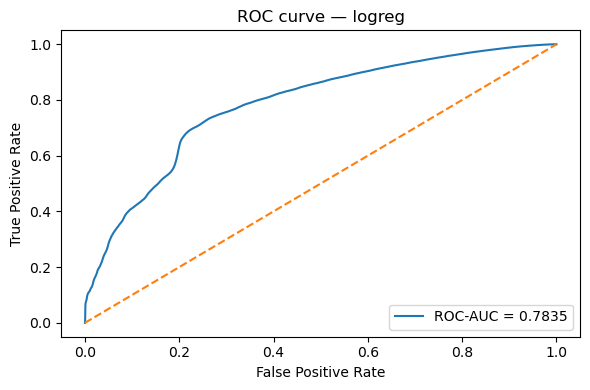

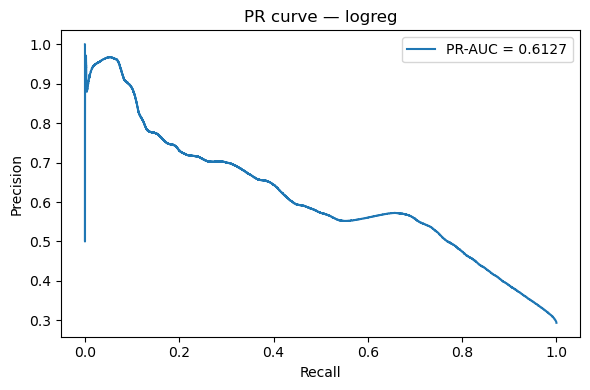

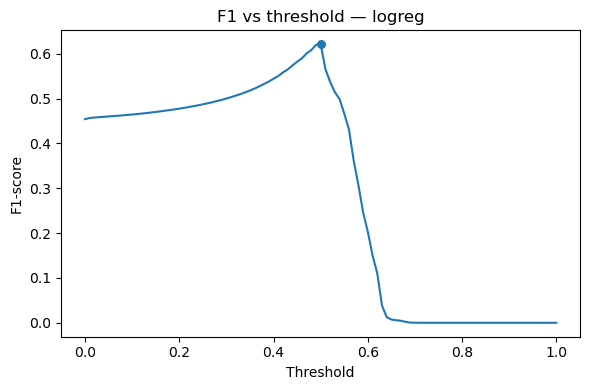

In [163]:
# Построение графиков
# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f'ROC-AUC = {roc_lr:.4f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curve — logreg')
plt.legend(loc='lower right'); plt.tight_layout()
plt.savefig(IMG_DIR / 'logreg_roc.png', dpi=150); plt.show()

# PR
plt.figure(figsize=(6, 4))
plt.plot(rec_curve_lr, prec_curve_lr, label=f'PR-AUC = {pr_lr:.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('PR curve — logreg')
plt.legend(loc='upper right'); plt.tight_layout()
plt.savefig(IMG_DIR / 'logreg_pr.png', dpi=150); plt.show()

# F1 vs threshold
f1_vals_lr = [f1_score(y_test, (proba_lr >= t).astype(int)) for t in thr_grid]
best_idx_lr = int(np.argmax(f1_vals_lr))
plt.figure(figsize=(6, 4))
plt.plot(thr_grid, f1_vals_lr)
plt.scatter(thr_grid[best_idx_lr], f1_vals_lr[best_idx_lr], s=30)
plt.xlabel('Threshold'); plt.ylabel('F1-score')
plt.title('F1 vs threshold — logreg')
plt.tight_layout()
plt.savefig(IMG_DIR / 'logreg_f1.png', dpi=150); plt.show()

In [164]:
# Сохранение модели
joblib.dump(final_lr, MODEL_DIR / 'logreg.pkl')

['models\\logreg.pkl']

### **4.2 Random Forest**

In [ ]:
thr_grid = np.linspace(0, 1, 101)

space_rf = {
    'n_estimators':     hp.choice('n_estimators', [300, 500, 800]),
    'max_depth':        hp.choice('max_depth', [None, 12, 18, 24]),
    'min_samples_split':hp.choice('min_samples_split', [2, 10, 50, 100]),
    'min_samples_leaf': hp.choice('min_samples_leaf',  [1, 2, 5, 20]),
    'max_features':     hp.choice('max_features', ['sqrt', 0.3, 0.5]),
}

def objective_rf(params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        bootstrap=True,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    best_thr, best_f1 = 0.5, float('-inf')
    for t in thr_grid:
        f = f1_score(y_test, (proba >= t).astype(int))
        if f > best_f1:
            best_f1, best_thr = f, t

    return {'loss': -best_f1, 'status': STATUS_OK, 'best_thr': best_thr, 'best_f1': best_f1, 'params': params}

trials_rf = Trials()
best_rf_raw = fmin(fn=objective_rf, space=space_rf, algo=tpe.suggest,
                   max_evals=40, trials=trials_rf, rstate=np.random.default_rng(RANDOM_STATE))

n_estimators_list     = [300, 500, 800]
max_depth_list        = [None, 12, 18, 24]
min_samples_split_list= [2, 10, 50, 100]
min_samples_leaf_list = [1, 2, 5, 20]
max_features_list     = ['sqrt', 0.3, 0.5]

best_rf_params = {
    'n_estimators':      n_estimators_list[best_rf_raw['n_estimators']],
    'max_depth':         max_depth_list[best_rf_raw['max_depth']],
    'min_samples_split': min_samples_split_list[best_rf_raw['min_samples_split']],
    'min_samples_leaf':  min_samples_leaf_list[best_rf_raw['min_samples_leaf']],
    'max_features':      max_features_list[best_rf_raw['max_features']],
}
print('Лучшие параметры RF (hyperopt):', best_rf_params)

In [ ]:
# Переобучаем финальную модель
rf = RandomForestClassifier(
    **best_rf_params,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:, 1]

# Порог по F1
best_thr_rf, best_f1_rf = 0.5, float('-inf')
for t in thr_grid:
    f = f1_score(y_test, (proba_rf >= t).astype(int))
    if f > best_f1_rf:
        best_f1_rf, best_thr_rf = f, t

# Метрики
y_pred_rf = (proba_rf >= best_thr_rf).astype(int)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, proba_rf)
prec_curve_rf, rec_curve_rf, _ = precision_recall_curve(y_test, proba_rf)
pr_rf = auc(rec_curve_rf, prec_curve_rf)

In [179]:
# Classification report
from sklearn.metrics import classification_report

y_pred_rf = (proba_rf >= best_thr).astype(int)
print(classification_report(y_test, y_pred_rf, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9275    1.0000    0.9624    570016
           1     0.9999    0.8123    0.8964    237226

    accuracy                         0.9448    807242
   macro avg     0.9637    0.9061    0.9294    807242
weighted avg     0.9488    0.9448    0.9430    807242



In [ ]:
# Построение графиков
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'ROC-AUC = {roc_rf:.4f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curve — rf'); plt.legend(loc='lower right'); plt.tight_layout()
plt.savefig(IMG_DIR / 'rf_roc.png', dpi=150); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(rec_curve_rf, prec_curve_rf, label=f'PR-AUC = {pr_rf:.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('PR curve — rf'); plt.legend(loc='upper right'); plt.tight_layout()
plt.savefig(IMG_DIR / 'rf_pr.png', dpi=150); plt.show()

f1_vals_rf = [f1_score(y_test, (proba_rf >= t).astype(int)) for t in thr_grid]
best_idx_rf = int(np.argmax(f1_vals_rf))
plt.figure(figsize=(6, 4))
plt.plot(thr_grid, f1_vals_rf); plt.scatter(thr_grid[best_idx_rf], f1_vals_rf[best_idx_rf], s=30)
plt.xlabel('Threshold'); plt.ylabel('F1-score')
plt.title('F1 vs threshold — rf'); plt.tight_layout()
plt.savefig(IMG_DIR / 'rf_f1.png', dpi=150); plt.show()

In [177]:
# Сохраняем модель
joblib.dump(rf, MODEL_DIR / 'rf.pkl')

['models\\rf.pkl']

### **4.3 Catboost**

In [ ]:
thr_grid = np.linspace(0, 1, 101)

space_cb = {
    'iterations':    hp.choice('iterations', [700, 900, 1100, 1300]),
    'depth':         hp.choice('depth', [6, 8, 10]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.20)),
    'l2_leaf_reg':   hp.loguniform('l2_leaf_reg',   np.log(1.0),   np.log(50.0)),
    'rsm': hp.uniform('rsm', 0.8, 1.0),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0)
}

def objective_cb(params):
    model = CatBoostClassifier(
        random_seed=RANDOM_STATE,
        auto_class_weights='Balanced',
        task_type='CPU',
        od_type='Iter',
        od_wait=50,
        verbose=False,
        **params
    )
    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
    proba = model.predict_proba(X_test)[:, 1]

    best_thr, best_f1 = 0.5, float('-inf')
    for t in thr_grid:
        f = f1_score(y_test, (proba >= t).astype(int))
        if f > best_f1:
            best_f1, best_thr = f, t

    return {'loss': -best_f1, 'status': STATUS_OK, 'best_thr': best_thr, 'best_f1': best_f1, 'params': params}

trials_cb = Trials()
best_cb_idx = fmin(fn=objective_cb, space=space_cb, algo=tpe.suggest,
                   max_evals=55, trials=trials_cb, rstate=np.random.default_rng(RANDOM_STATE))


In [85]:
from hyperopt import space_eval

best_cb_params = space_eval(space_cb, best_cb_idx)
print('Лучшие параметры CatBoost (hyperopt):', best_cb_params)

Лучшие параметры CatBoost (hyperopt): {'bagging_temperature': 0.02209643471772524, 'depth': 8, 'iterations': 1300, 'l2_leaf_reg': 2.0806787921226686, 'learning_rate': 0.055448165821251644, 'rsm': 0.9983227433971491}


In [ ]:
# Обучим финальную модель

cb = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    auto_class_weights='Balanced',
    task_type='CPU',
    od_type='Iter',
    od_wait=50,
    verbose=True,
    **best_cb_params
)
cb.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

proba_cb = cb.predict_proba(X_test)[:, 1]

best_thr_cb, best_f1_cb = 0.5, float('-inf')
for t in thr_grid:
    f = f1_score(y_test, (proba_cb >= t).astype(int))
    if f > best_f1_cb:
        best_f1_cb, best_thr_cb = f, t

y_pred_cb = (proba_cb >= best_thr_cb).astype(int)
precision_cb = precision_score(y_test, y_pred_cb, zero_division=0)
recall_cb = recall_score(y_test, y_pred_cb)
roc_cb = roc_auc_score(y_test, proba_cb)
prec_curve_cb, rec_curve_cb, _ = precision_recall_curve(y_test, proba_cb)
pr_cb = auc(rec_curve_cb, prec_curve_cb)

print('CatBoost: F1 =', round(best_f1_cb,4), 'thr =', round(best_thr_cb,2))

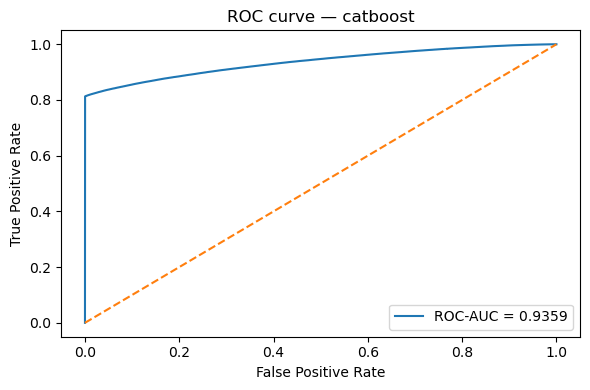

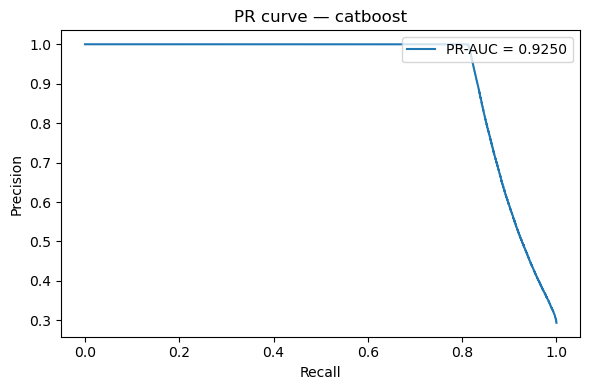

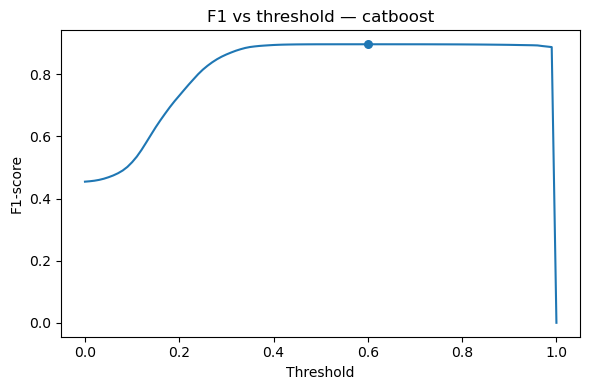

In [93]:
# Построим графики
# ROC
fpr_cb, tpr_cb, _ = roc_curve(y_test, proba_cb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_cb, tpr_cb, label=f'ROC-AUC = {roc_cb:.4f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curve — catboost'); plt.legend(loc='lower right'); plt.tight_layout()
plt.savefig(IMG_DIR / 'catboost_roc.png', dpi=150); plt.show()

# PR
plt.figure(figsize=(6, 4))
plt.plot(rec_curve_cb, prec_curve_cb, label=f'PR-AUC = {pr_cb:.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('PR curve — catboost'); plt.legend(loc='upper right'); plt.tight_layout()
plt.savefig(IMG_DIR / 'catboost_pr.png', dpi=150); plt.show()

# F1
f1_vals_cb = [f1_score(y_test, (proba_cb >= t).astype(int)) for t in thr_grid]
best_idx_cb = int(np.argmax(f1_vals_cb))
plt.figure(figsize=(6, 4))
plt.plot(thr_grid, f1_vals_cb)
plt.scatter(thr_grid[best_idx_cb], f1_vals_cb[best_idx_cb], s=30)
plt.xlabel('Threshold'); plt.ylabel('F1-score')
plt.title('F1 vs threshold — catboost'); plt.tight_layout()
plt.savefig(IMG_DIR / 'catboost_f1.png', dpi=150); plt.show()

In [90]:
# Сохраним модель
cb.save_model(MODEL_DIR / 'catboost.cbm')
print('Model is saved')

Model is saved


## **5. Submissions**

In [95]:
X_submit = test.reindex(columns=X.columns).copy()
loan_id_submit = test['loan_id'].copy()

proba_test = cb.predict_proba(X_submit)[:, 1]
pred_test = (proba_test >= best_thr_cb).astype(int)

submission = pd.DataFrame({
    'loan_id': loan_id_submit,
    'churn': pred_test
})
submission.to_csv('submission.csv', index=False)

submission.head()

,loan_id,churn
0,4057275,1
1,548313,1
2,1978430,1
3,2884196,1
4,3647374,1
